In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

- http://networkrepository.com/citeseer.php
- http://snap.stanford.edu/data/ca-GrQc.html

In [2]:
# citeseer data
edges = pd.read_csv('./data/citeseer.edges',header=None,names=['s','t','w'])
nodes = pd.read_csv('./data/citeseer.node_labels',header=None,names=['node','y'])

***Create undirected graph***

In [34]:
G=nx.Graph(name='citeseer')
for x in list(nodes['node'].unique()): G.add_node(x) 
G.add_edges_from([(i,e,{'weight':1}) for i,e in edges[['s','t']].values])

G.graph
# view
# G.edges(data=True)

{'name': 'citeseer'}

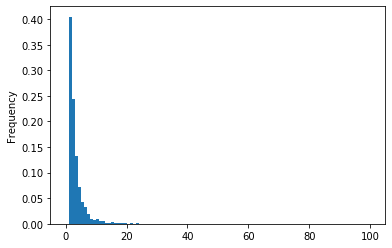

In [70]:
node_degree = [i for i in nx.degree(G)]
node_degree = pd.DataFrame(node_degree,columns=['node','degree'])
node_degree['degree'].plot.hist(density=True,bins=np.arange(0,101,1));

In [77]:
sg = [G.subgraph(c) for c in nx.connected_components(G)]
print(f'Subgraphs: {len(sg)}')
pd.DataFrame([len(g) for g in sg]).describe().T

Subgraphs: 390


,count,mean,std,min,25%,50%,75%,max
0,390.0,8.369231,106.714751,2.0,2.0,2.0,3.0,2110.0


***View the graph***

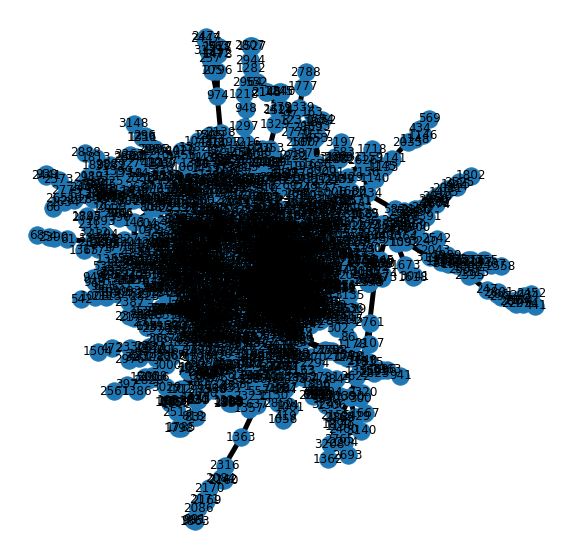

In [61]:
fig,ax = plt.subplots(1,1, figsize=(10,10))

nx.draw_spring(sg[0], ax=ax,
               #node_size=degree*100,
               with_labels=True,
               cmap = plt.get_cmap('jet'),
               #node_color = values,
               width=5)

***Node2Vec***

The node2vec framework learns low-dimensional representations for nodes in a graph by optimizing a neighborhood preserving objective. The objective is flexible, and the algorithm accomodates for various definitions of network neighborhoods by simulating biased random walks. Specifically, it provides a way of balancing the exploration-exploitation tradeoff that in turn leads to representations obeying a spectrum of equivalences from homophily to structural equivalence. [ref](https://snap.stanford.edu/node2vec/)

 - https://github.com/eliorc/node2vec
 - [snap implementation](https://snap.stanford.edu/node2vec/)
 
[*node2vec: Scalable Feature Learning for Networks. A. Grover, J. Leskovec. ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 2016.*](http://arxiv.org/abs/1607.00653)


In [78]:
from node2vec import Node2Vec

In [79]:
# pre-compute the probabilities and generate walks :
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)

Computing transition probabilities: 100%|██████████| 3264/3264 [00:00<00:00, 4716.80it/s]


In [80]:
# We can then embed the nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [82]:
import pickle
pickle.dump(node2vec, open( "n2v-node2vec.p", "wb" ))
pickle.dump(model, open( "n2v-model.p", "wb" ))

It has a length of 64 since we defined the dimension as 64 above. What can we do with this embedding? One of the first options is for example to identify the most similar node!

In [83]:
model.wv.get_vector('1')

array([-1.0837638 , -0.37667176, -3.2945633 ,  2.6422124 , -0.5649044 ,
       -1.5507184 ,  1.186665  ,  3.597253  , -2.7816567 ,  2.575173  ,
        0.04110461,  1.6631413 , -2.2702563 ,  0.4321783 ,  2.0224702 ,
       -1.9222032 , -3.7556794 ,  0.7933126 ,  0.05108364,  0.9295924 ,
       -0.26672342,  1.5952365 ,  0.76450956, -0.80736005,  2.1242707 ,
       -2.3169124 ,  0.4371    ,  1.4788774 , -0.2950616 ,  1.4724796 ,
       -0.28624249, -0.25213444,  1.1692222 , -0.01388963, -0.953537  ,
       -2.6818295 , -0.95045096, -1.9056246 ,  1.7256726 ,  0.09131712,
        1.9337454 , -0.44178858,  1.3095589 , -1.3865978 ,  1.4046385 ,
       -0.81186694, -0.1369187 ,  1.0147077 ,  1.1231419 , -0.3010664 ,
        1.3778569 ,  2.5733347 , -2.2399974 ,  2.0692735 ,  1.7534308 ,
        3.7642944 ,  2.8506467 ,  0.99276114, -2.687533  , -1.203547  ,
        1.188889  ,  1.3751438 ,  1.601147  , -0.27851757], dtype=float32)

In [89]:
model.wv.most_similar('1')

[('691', 0.9857870936393738),
 ('2501', 0.9855062961578369),
 ('734', 0.9847098588943481),
 ('758', 0.9819974899291992),
 ('187', 0.9816461801528931),
 ('836', 0.9814138412475586),
 ('621', 0.9803900718688965),
 ('612', 0.978644609451294),
 ('759', 0.978423535823822),
 ('38', 0.9777191877365112)]

In [87]:
node_degree.loc[node_degree['node'].isin([1,691,2501,734,758,187,836,621,612,759,38])]

,node,degree
0,1,1
37,38,1
186,187,1
611,612,1
620,621,1
690,691,1
733,734,1
757,758,1
758,759,1
835,836,1


If the nodes have labels, we can train an algorithm based on the embedding and attach a label (node labeling, most similar node…)